In [1]:
import os

INPUT_DIR = '../input/hasoc-2020-en/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC,LinearSVC
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import keras.layers as L
from keras import Model
stop_words = stopwords.words('english')

# change cfg and run train_func to get result

note all cells till train_func must be run in sequence last 2 cell are for voting<br>
dataset used can be found at:- https://www.kaggle.com/datasets/mrigendraagrawal/liar-dataset

In [3]:
!unzip /kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
!unzip /kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip

Archive:  /kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
  inflating: train.tsv               
Archive:  /kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip
  inflating: test.tsv                


In [4]:
class CFG:
    model = 'SVM' #(LogisticRegression,SVM,'naive_bayes','xgboost','RandomForest')
    method = 'TFid'   #(TFid,CountVectorizer)

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


In [6]:
pd.read_csv('/kaggle/working/train.tsv',sep='\t')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [7]:
train = pd.read_csv('/kaggle/working/train.tsv',sep='\t')
test = train.tail(20000).copy()
train = train.head(120000).copy()

print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
display(train.head())
display(test.head())

train.shape: (120000, 4)
test.shape: (20000, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


,PhraseId,SentenceId,Phrase,Sentiment
136060,136061,7350,an engrossing thriller almost in spite of itself,3
136061,136062,7350,an engrossing thriller,4
136062,136063,7350,engrossing thriller,3
136063,136064,7350,almost in spite of itself,2
136064,136065,7350,in spite of itself,2


In [8]:
stemmer  = SnowballStemmer(language='english')
def preprocessing(phrase):
    lower = [phrase.lower() for phrase in phrase]
    no_punct = [text.translate(str.maketrans('','',string.punctuation)) for text in lower]
    stem = [stemmer.stem(i) for i in no_punct]
    join = ["".join(text) for text in stem]
    return join

In [9]:
#mapper = {'HOF':1,'NOT':0}
#train['text'] = train['Comment']
#test['text'] = test['Comment']
display(train.head())
#display(test.head())
train['label'] = train['Sentiment']
test['label'] = test['Sentiment']
#test['label'] = test['HS']
#train['label'] = train['label'].map(mapper)
#test['label'] = test['label'].map(mapper)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [10]:
train

,PhraseId,SentenceId,Phrase,Sentiment,label
0,1,1,A series of escapades demonstrating the adage ...,1,1
1,2,1,A series of escapades demonstrating the adage ...,2,2
2,3,1,A series,2,2
3,4,1,A,2,2
4,5,1,series,2,2
...,...,...,...,...,...
119995,119996,6419,For casual moviegoers who stumble into Rules e...,2,2
119996,119997,6419,casual moviegoers who stumble into Rules expec...,2,2
119997,119998,6419,casual moviegoers,2,2
119998,119999,6419,who stumble into Rules expecting a slice of Am...,1,1


In [11]:
test

,PhraseId,SentenceId,Phrase,Sentiment,label
136060,136061,7350,an engrossing thriller almost in spite of itself,3,3
136061,136062,7350,an engrossing thriller,4,4
136062,136063,7350,engrossing thriller,3,3
136063,136064,7350,almost in spite of itself,2,2
136064,136065,7350,in spite of itself,2,2
...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,2
156056,156057,8544,forced avuncular chortles,1,1
156057,156058,8544,avuncular chortles,3,3
156058,156059,8544,avuncular,2,2


<AxesSubplot:>

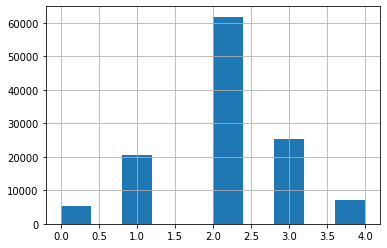

In [12]:
train['label'].hist()

In [13]:
train['Phrase'] = preprocessing(train['Phrase'])
test['Phrase'] = preprocessing(test['Phrase'])

In [14]:
xtrain = train['Phrase'].copy()
ytrain = train['label'].copy()

In [15]:
xtrain

0         a series of escapades demonstrating the adage ...
1         a series of escapades demonstrating the adage ...
2                                                    a seri
3                                                         a
4                                                      seri
                                ...                        
119995    for casual moviegoers who stumble into rules e...
119996    casual moviegoers who stumble into rules expec...
119997                                       casual moviego
119998    who stumble into rules expecting a slice of am...
119999    stumble into rules expecting a slice of americ...
Name: Phrase, Length: 120000, dtype: object

In [22]:
def train_func():
    if CFG.method == 'TFid':
        vectorizer = TfidfVectorizer( stop_words = 'english')

    elif CFG.method == 'CountVectorizer':
        vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), stop_words = 'english')


    vectorizer.fit(train['Phrase'])
    xtrain_transform =  vectorizer.transform(xtrain) 
    xtest = test['Phrase']
    xtest_transform = vectorizer.transform(xtest)
    
    #print('tfidf transforming complete')

    if CFG.model == 'LogisticRegression':
        clf = LogisticRegression(C=1.0)

    elif CFG.model == 'SVM':
        clf = LinearSVC(C=1.0)#,probability=True)

    elif CFG.model == 'naive_bayes':
        clf = MultinomialNB()

    elif CFG.model == 'xgboost':
        clf = xgb.XGBClassifier(learning_rate=0.1,colsample_bytree=0.2,gamma=1.015995756910978,max_depth=15,min_child_weight=15,reg_alpha=2,reg_lambda=0.001)
    
    elif CFG.model =='RandomForest':
        clf = RandomForestClassifier()

    print('='*10)    
    print(f'using method {CFG.method}')
    print('='*10)
    if CFG.model != 'xgboost':
        clf.fit(xtrain_transform, ytrain)
    else:
        clf.fit(xtrain_transform,ytrain,early_stopping_rounds=200,eval_set=[(xvalid_transform,yvalid)], verbose=False)
    #predictions = clf.predict_proba(xvalid_transform)
    #predictions = np.argmax(predictions,axis=1).reshape(-1,1)
    #print(f'valid accuracy score using {CFG.model} is: ',accuracy_score(yvalid,predictions))
    #print(f'valid auc score using {CFG.model} is: ',roc_auc_score(yvalid,predictions))
    #test_predictions = clf.predict_proba(xtest_transform)
    test_predictions = clf.predict(xtest_transform)
    #test_predictions = np.argmax(test_predictions,axis=1).reshape(-1,1)
    print(f'test accuracy score using {CFG.model} is: ',accuracy_score(test['label'],test_predictions))
    #print(f'test auc score using {CFG.model} is: ',roc_auc_score(test['label'],test_predictions))
    print('='*10)
    return vectorizer, test_predictions, clf

In [23]:
vectorizer, test_predictions, clf = train_func()

using method TFid
test accuracy score using SVM is:  0.56445


In [26]:
test['Phrase'].iloc[0]

'an engrossing thriller almost in spite of itself'

In [39]:
test_samples = ['worst youtube video ever']

test_samples_vec = vectorizer.transform(test_samples)

In [40]:
preds = clf.predict(test_samples_vec)

In [41]:
preds

array([0])